In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Wave7.csv')
data.head()

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070001,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070002,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070003,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070005,...,66.964286,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [3]:
# countries = data[(data['B_COUNTRY_ALPHA'] == 'IND') | (data['B_COUNTRY_ALPHA'] == 'USA') | (data['B_COUNTRY_ALPHA'] == 'DEU')]

data[(data['B_COUNTRY_ALPHA'] == 'USA') | (data['B_COUNTRY_ALPHA'] == 'IND')].shape

(4288, 613)

In [4]:
cleaned_dataset = data[(data['B_COUNTRY_ALPHA'] == 'USA') | (data['B_COUNTRY_ALPHA'] == 'IND')]
cleaned_dataset.reset_index(drop = True, inplace = True)

cat_cols = list(set(cleaned_dataset.columns)-{'Y001','Y002','Y003','SACSECVAL', 'RESEMAVAL','I_AUTHORITY',  'I_NATIONALISM',  'I_DEVOUT',  'DEFIANCE',  'I_RELIGIMP',  'I_RELIGBEL',  'I_RELIGPRAC',  'DISBELIEF',  'I_NORM1',  'I_NORM2',  'I_NORM3',  'RELATIVISM',  'I_TRUSTARMY',  'I_TRUSTPOLICE',  'I_TRUSTCOURTS',  'SCEPTICISM',  'I_INDEP',  'I_IMAGIN',  'I_NONOBED',  'AUTONOMY',  'I_WOMJOB',  'I_WOMPOL',  'I_WOMEDU',  'EQUALITY',  'I_HOMOLIB',  'I_ABORTLIB',  'I_DIVORLIB',  'CHOICE',  'I_VOICE1',  'I_VOICE2',  'I_VOI2_00',  'VOICE',  'SECVALWGT',  'RESEMAVALWGT'})
cleaned_dataset[cat_cols] = cleaned_dataset[cat_cols].astype('category')

pd.options.display.max_columns = None

required_cols = ['B_COUNTRY_ALPHA','Q222','Q221','Q49','Q260','Q262','Q263','Q274','Q288','Q275','Q164','Q172R','Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']
cleaned_dataset = cleaned_dataset[required_cols]

ethical_values = ['Q177','Q178','Q179','Q180','Q181','Q182','Q183','Q184','Q185','Q186','Q187','Q188','Q189','Q190','Q191','Q192','Q193','Q194','Q195']

# reverse the score for columns such that in the end 1 is bad and 10 is good
reverse_scoring = ['Q177','Q178','Q179','Q180','Q181','Q183','Q187','Q188','Q189','Q190','Q191','Q192','Q194','Q195']

for col in ethical_values:
    cleaned_dataset[col] = pd.to_numeric(cleaned_dataset[col], errors='coerce')  # Convert to numeric, NaNs for invalid
    cleaned_dataset[col] = cleaned_dataset[col].where(cleaned_dataset[col] >= 0, np.nan)  # Replace negative values with NaN

for col in reverse_scoring:
    cleaned_dataset[col] = 11 - cleaned_dataset[col]

# Ethics score is the average score of all questions
cleaned_dataset['ethics_score'] = cleaned_dataset[ethical_values].mean(axis=1)

# Normalized ethics score
min_score = cleaned_dataset['ethics_score'].min()
max_score = cleaned_dataset['ethics_score'].max()
cleaned_dataset['ethics_score'] = 10 * (cleaned_dataset['ethics_score'] - min_score) / (max_score - min_score)

cleaned_dataset.drop(columns=ethical_values, inplace=True)

cleaned_dataset.rename(columns={
    'Q262':'age', 
    'Q263':'immigrant', 
    'Q274':'children', 
    'Q275':'education', 
    'Q260':'sex', 
    'Q222':'voter_national',
    'Q221':'voter_local',
    'Q164':'god_importance',
    'Q172R':'praying_frequency',
    'Q49':'satisfaction',
    'Q288':'income_level',
    'B_COUNTRY_ALPHA':'country'
    }, inplace=True)

# For each respondent:
#     IF voter_national == 4 OR voter_local == 4 THEN
#         target = 0  # Not allowed to vote
#     ELSE:
#         IF voter_national == 1 OR voter_local == 1 THEN
#             target = 3  # Always votes (high engagement)
#         ELSE IF voter_national == 2 OR voter_local == 2 THEN
#             IF voter_national == 3 OR voter_local == 3 THEN
#                 target = 1  # Sometimes votes but inconsistent
#             ELSE:
#                 target = 2  # Usually votes
#         ELSE:
#             target = 1  # Never votes (low engagement)
cleaned_dataset['voter_3'] = -1
for i in range(len(cleaned_dataset)):
    national = cleaned_dataset.loc[i, 'voter_national']
    local = cleaned_dataset.loc[i, 'voter_local']

    if national == 4 | local == 4:
        cleaned_dataset.loc[i, 'voter_3'] = 1
    elif national == 1 | local == 1:
        cleaned_dataset.loc[i, 'voter_3'] = 3
    elif national == 2 | local == 2:
        if national == 3 | local == 3:
            cleaned_dataset.loc[i, 'voter_3'] = 1
        else:
            cleaned_dataset.loc[i, 'voter_3'] = 2
    else:
        cleaned_dataset.loc[i, 'voter_3'] = 1
cleaned_dataset['voter_2'] = np.where(cleaned_dataset['voter_national'].isin([4]) | cleaned_dataset['voter_local'].isin([4]),0,np.where(cleaned_dataset['voter_national'].isin([1,2]) | cleaned_dataset['voter_local'].isin([1,2]),1,0))

# Null if both voter_local and voter_national is null
cleaned_dataset.loc[cleaned_dataset['voter_national'].isnull() & cleaned_dataset['voter_local'].isnull(), ['voter_3', 'voter_2']] = None

cleaned_dataset.drop(columns=['voter_national','voter_local'], inplace=True)

# Set datatypes

cleaned_dataset[['satisfaction','god_importance', 'age', 'children']] = cleaned_dataset[['satisfaction','god_importance', 'age', 'children']].astype('int')
cleaned_dataset[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_3']] = cleaned_dataset[['income_level', 'education', 'praying_frequency', 'voter_2', 'voter_3']].astype('int')
cleaned_dataset['country'] = cleaned_dataset['country'].astype('str')
cleaned_dataset['ethics_score'] = cleaned_dataset['ethics_score'].astype('float').apply(lambda x: round(x, 2))

to_clean = ['satisfaction', 'immigrant', 'children', 'income_level', 'education', 'god_importance', 'praying_frequency', 'voter_2', 'voter_3']
for col in to_clean:
    cleaned_dataset[col] = np.where(cleaned_dataset[col].astype(int) >= 0, cleaned_dataset[col], None)

cleaned_dataset['sex'] = np.where(cleaned_dataset['sex'] == 1, 'Male', 'Female')
cleaned_dataset['immigrant'] = np.where(cleaned_dataset['immigrant'] == 1, 'Not immigrant', 'Immigrant')

# cleaned_dataset.to_csv('cleaned_dataset.csv')

cleaned_dataset.head()


,country,satisfaction,sex,age,immigrant,children,income_level,education,god_importance,praying_frequency,ethics_score,voter_3,voter_2
0,IND,4,Female,20,Not immigrant,None,4,6,8,1,7.59,3,1
1,IND,6,Male,63,Not immigrant,3,5,3,10,1,7.28,1,1
2,IND,10,Male,17,Not immigrant,None,1,1,1,1,6.66,3,1
3,IND,5,Female,68,Not immigrant,4,7,0,10,1,5.36,3,1
4,IND,7,Male,55,Not immigrant,1,4,6,10,1,6.47,3,1


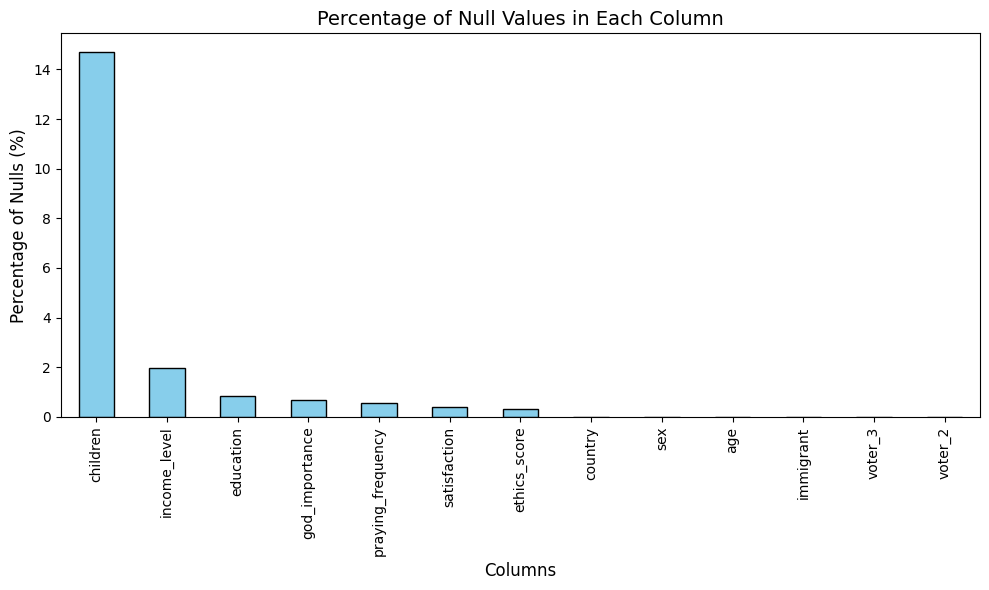

In [5]:
import matplotlib.pyplot as plt

# Calculate the percentage of null values for each column
null_percentages = cleaned_dataset.isna().mean() * 100

# Plot the percentages
plt.figure(figsize=(10, 6))
null_percentages.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Null Values in Each Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Nulls (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [88]:
# Set cases where number of children is not given to 0
cleaned_dataset['children'].fillna(0, inplace=True)

rows_with_nulls = cleaned_dataset.isnull().any(axis=1).sum()
total_rows = len(cleaned_dataset)

print("Null rows: ", rows_with_nulls, "\n", "Total rows: ", total_rows, "\n", "Percentage rows with nulls: ", 100*rows_with_nulls/total_rows)

Null rows:  142 
 Total rows:  4288 
 Percentage rows with nulls:  3.3115671641791047


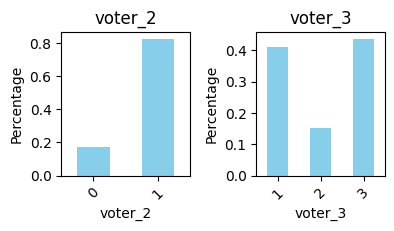

In [89]:
plt.figure(figsize=(6, 4))

plt.subplot(2, 3, 1)

cleaned_dataset['voter_2'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title('voter_2')
plt.xlabel('voter_2')
plt.ylabel('Percentage')

plt.xticks(rotation=45)

plt.subplot(2, 3, 2)

cleaned_dataset['voter_3'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title('voter_3')
plt.xlabel('voter_3')
plt.ylabel('Percentage')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
filtered_dataset = cleaned_dataset.dropna()
filtered_dataset.to_csv('full_dataset.csv', index=False)

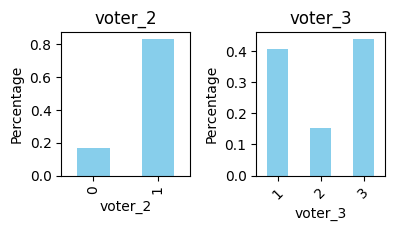

In [9]:
plt.figure(figsize=(6, 4))

plt.subplot(2, 3, 1)

filtered_dataset['voter_2'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title('voter_2')
plt.xlabel('voter_2')
plt.ylabel('Percentage')

plt.subplot(2, 3, 2)

filtered_dataset['voter_3'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
plt.title('voter_3')
plt.xlabel('voter_3')
plt.ylabel('Percentage')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

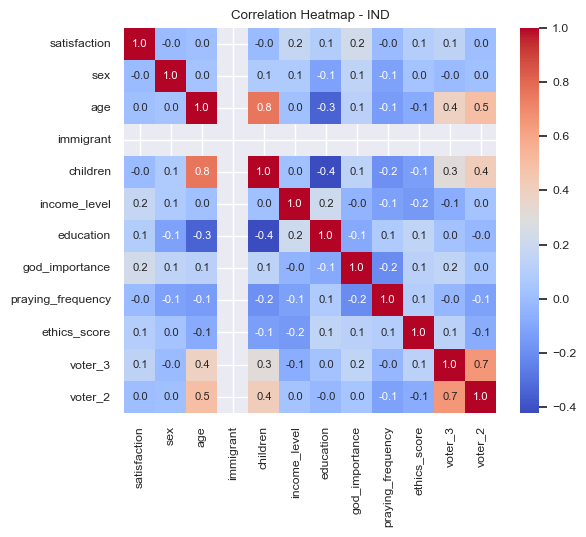

In [11]:
# cleaned_dataset.reset_index(inplace=True, drop=True)

cleaned_dataset_numeric = filtered_dataset.copy(deep=True)
cleaned_dataset_numeric['country'] = np.where(cleaned_dataset_numeric['country'] == 'USA', 0, 1)
cleaned_dataset_numeric['sex'] = np.where(cleaned_dataset_numeric['sex'] == 'Female', 1, 0)
cleaned_dataset_numeric['immigrant'] = np.where(cleaned_dataset_numeric['immigrant'] == 'Not immigrant', 0, 1)

# Select country here: IND = 1 , USA = 0
cleaned_dataset_numeric = cleaned_dataset_numeric[cleaned_dataset_numeric['country'] == 1].drop(columns=['country'])

corr_matrix = cleaned_dataset_numeric.corr(method='spearman')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f", annot_kws={'size': 8})
plt.title("Correlation Heatmap - IND")
plt.show()

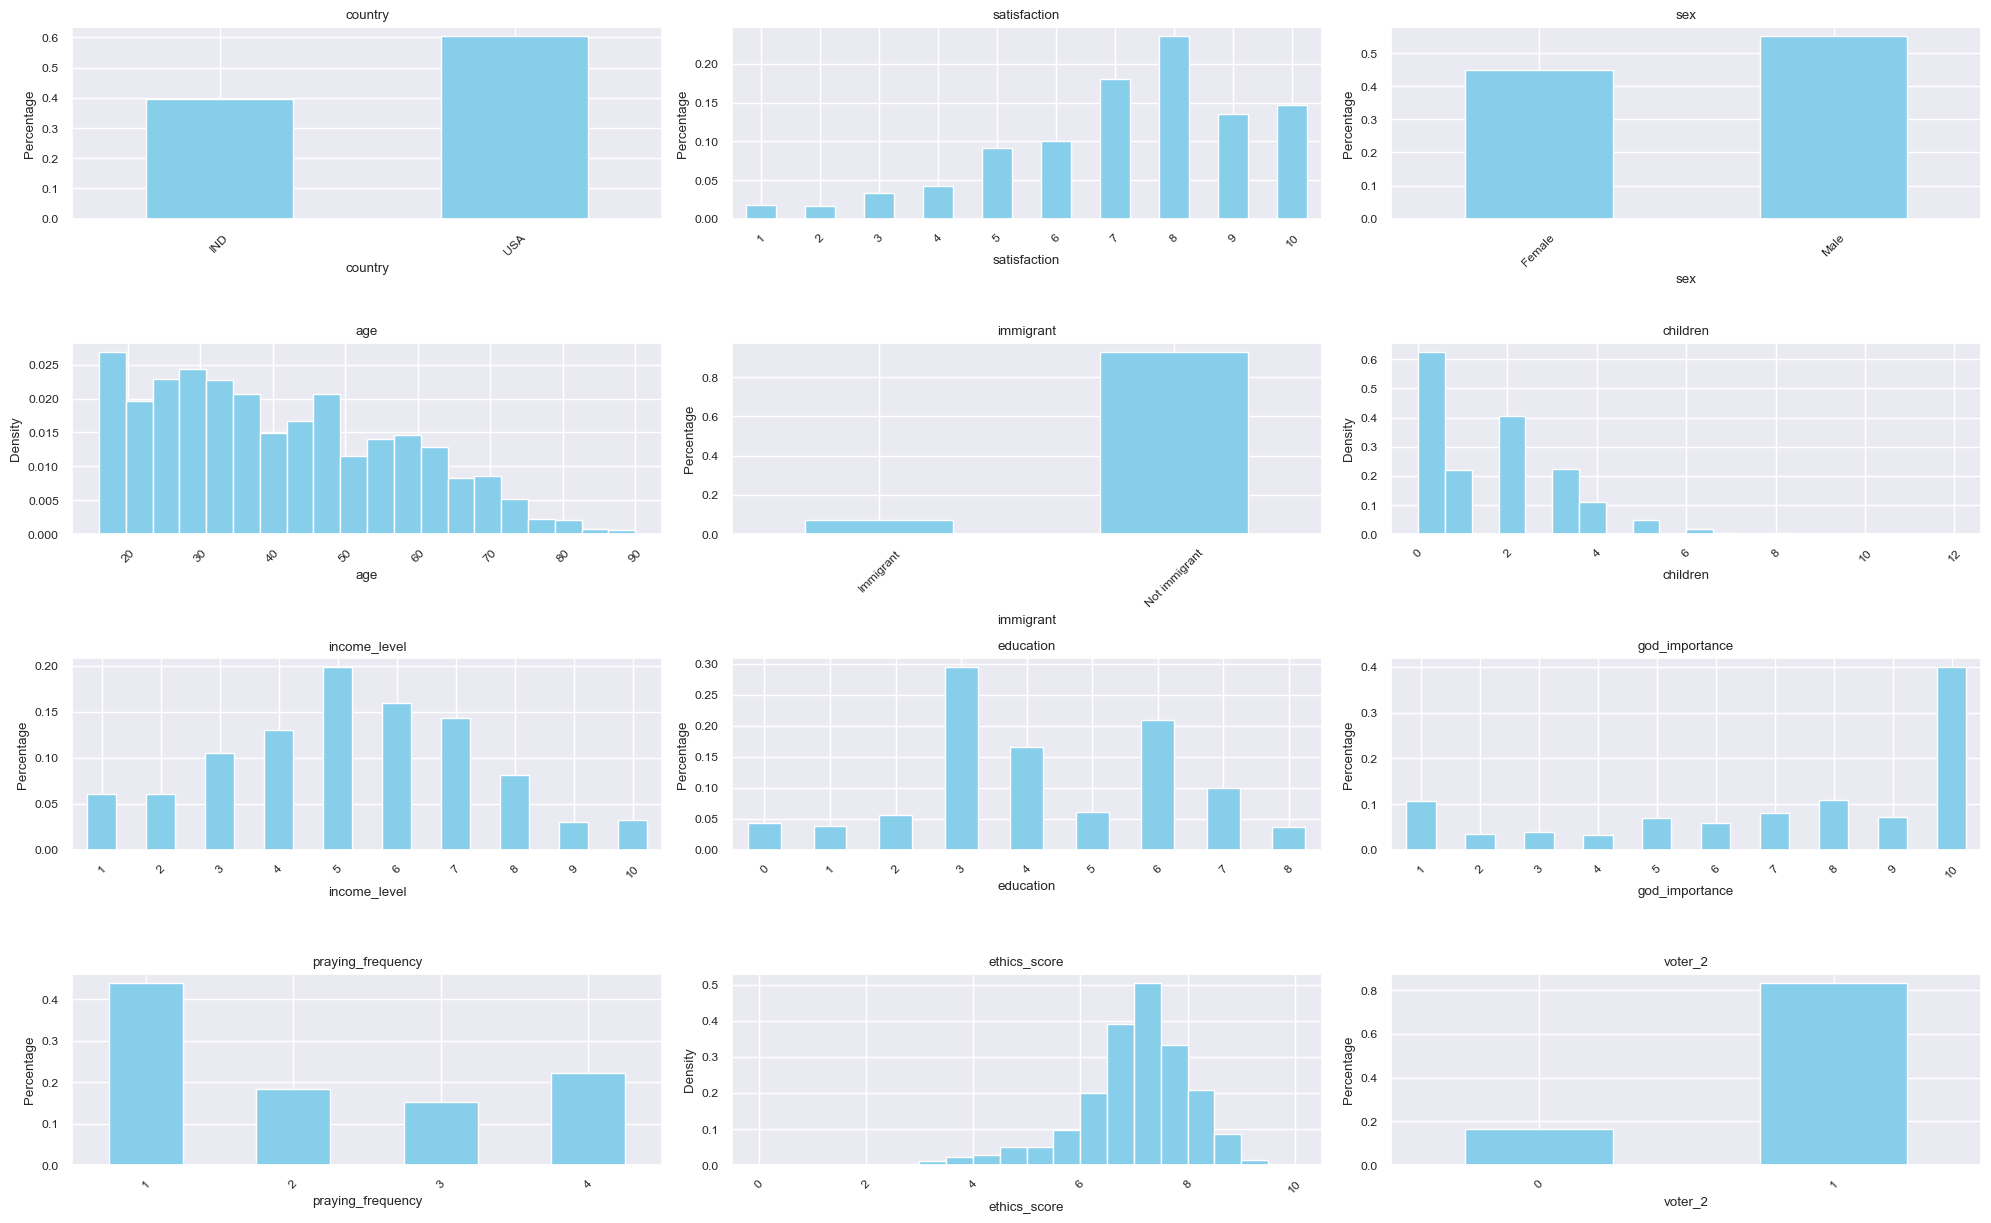

In [12]:
import matplotlib.pyplot as plt

# Plot histograms for each column
filtered_dataset.drop(columns=['voter_3'], inplace=True)
columns = filtered_dataset.columns
num_columns = len(columns)

plt.figure(figsize=(20, 15))

for i, column in enumerate(columns):
    plt.subplot((num_columns // 3) + 1, 3, i + 1)
    
    # Plot histogram for numeric columns
    if filtered_dataset[column].dtype in ['int64', 'float64']:
        filtered_dataset[column].plot(kind='hist', bins=20, color='skyblue', density=True)
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Density')
    # Plot histogram for categorical columns
    else:
        filtered_dataset[column].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Percentage')
    
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

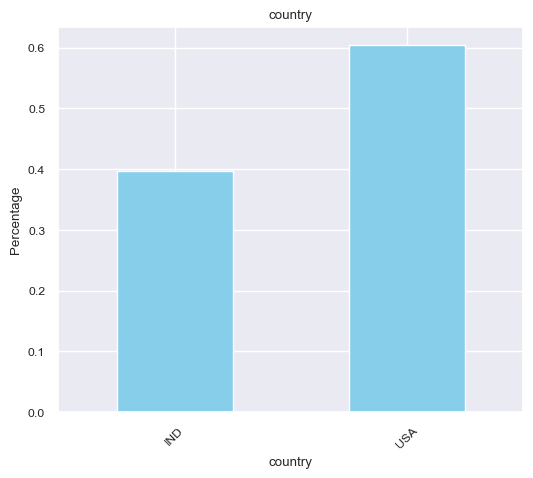

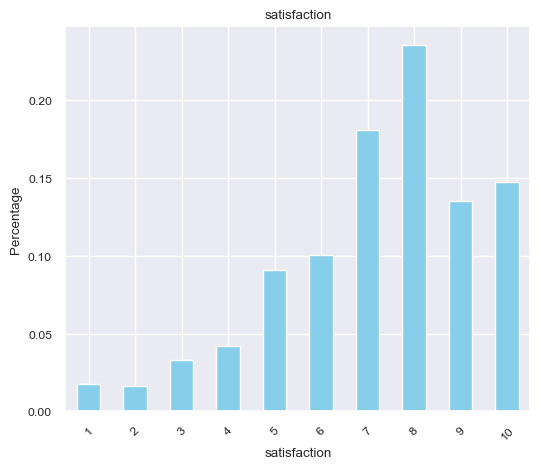

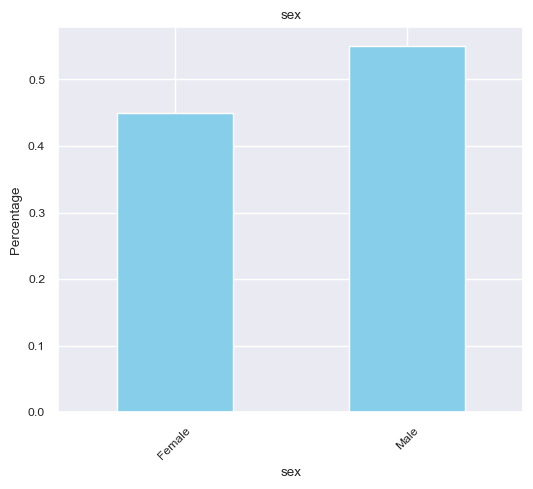

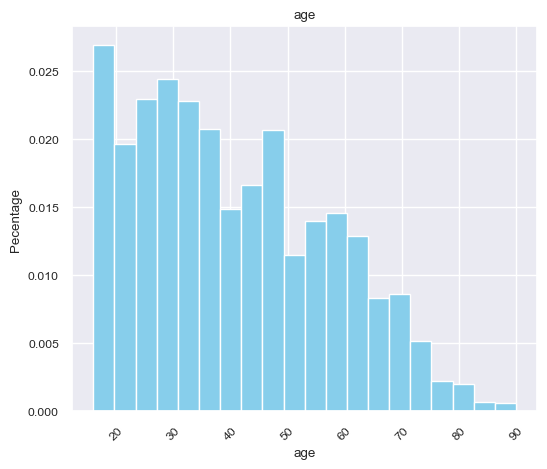

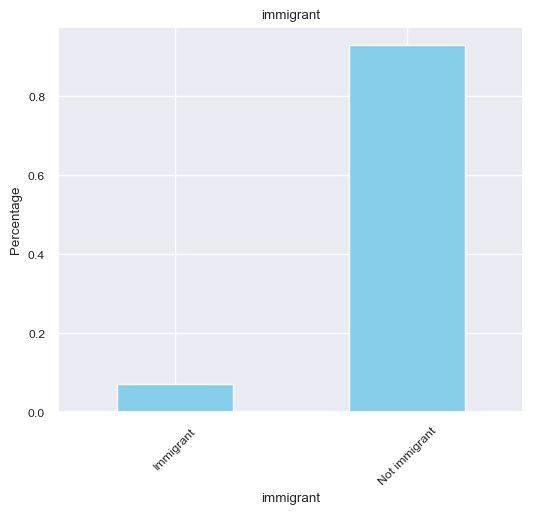

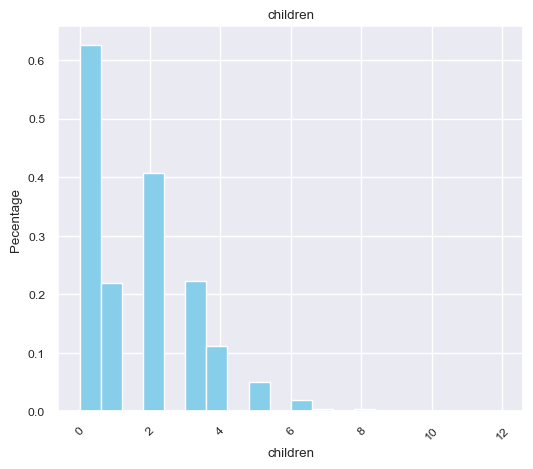

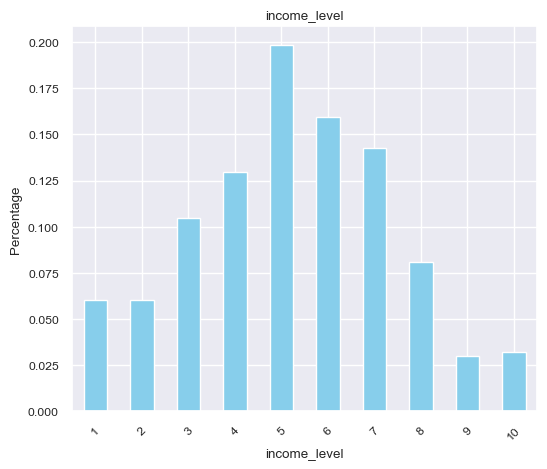

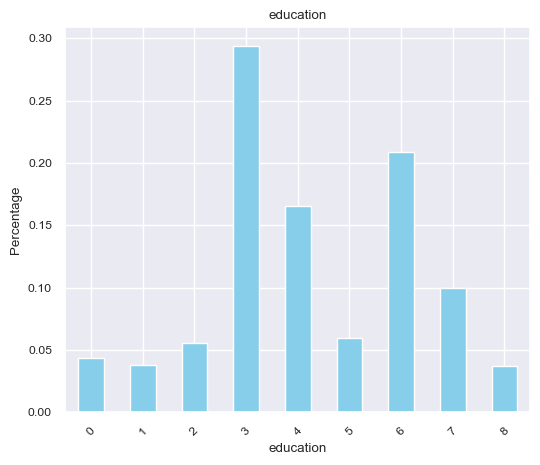

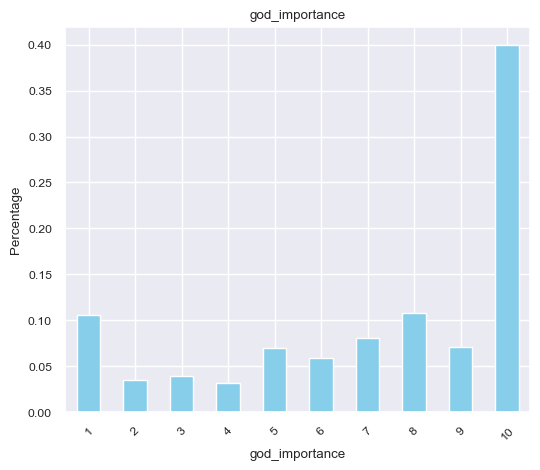

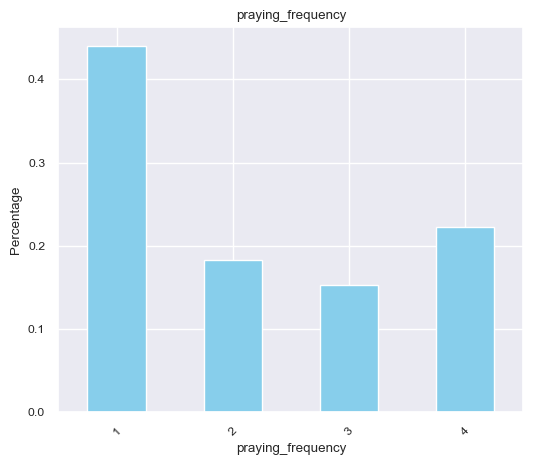

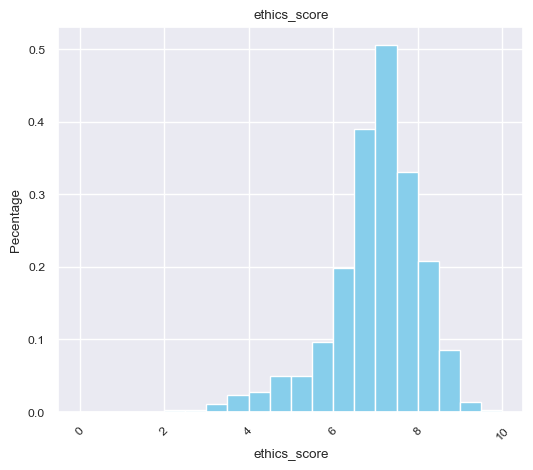

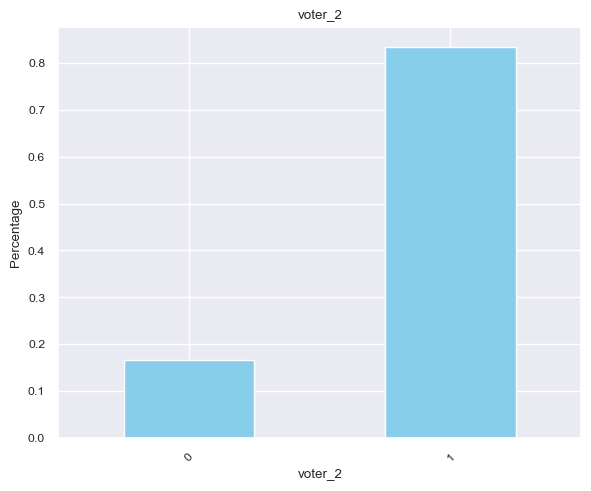

In [13]:
columns = filtered_dataset.columns

for column in columns:
    plt.figure(figsize=(6, 5))

    if filtered_dataset[column].dtype in ['int64', 'float64']:
        filtered_dataset[column].plot(kind='hist', bins=20, color='skyblue', density=True)
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Pecentage')
    else:
        filtered_dataset[column].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.ylabel('Percentage')
    
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()